In [1]:
import os, sys, math, time, json, random, csv, gc, re
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

sys.path.append(str(Path.cwd().parents[1])) 
import KEYS


from datasets import Dataset
from transformers import (
    AutoConfig, AutoTokenizer, AutoModelForCausalLM,
    DataCollatorForLanguageModeling, TrainingArguments, Trainer
)
from transformers.trainer_callback import TrainerCallback, EarlyStoppingCallback
from peft import LoraConfig, get_peft_model

# ----------------------------
# CONFIGURACIÓN
# ----------------------------
#MODEL_ID = os.getenv("MODEL_ID", "Qwen/Qwen2.5-3B-Instruct")  
MODEL_ID = os.getenv("MODEL_ID", "Qwen/Qwen2.5-7B-Instruct")
HF_TOKEN = os.getenv("HF_TOKEN", None)                                  
DEVICE   = "cuda" if torch.cuda.is_available() else "cpu"

CUT_OFF_LEN     = int(os.getenv("CUT_OFF_LEN", "1024"))    # longitud máxima del texto de entrada (tokens)
MAX_NEW_TOKENS  = int(os.getenv("MAX_NEW_TOKENS", "1024")) # límite de tokens que puede generar el modelo
TEMPERATURE     = float(os.getenv("TEMPERATURE", "0.2"))   # controla la aleatoriedad (más bajo = más determinista)
TOP_P           = float(os.getenv("TOP_P", "0.95"))        # limita la generación a los tokens más probables (≈TOP_P % de probabilidad acumulada)
N_TRAIN         = int(os.getenv("N_TRAIN", "1500"))        # número de muestras de entrenamiento (subconjunto)
EVAL_STEPS      = int(os.getenv("EVAL_STEPS", "10"))       # cada cuántos pasos se evalúa el modelo
LOG_STEPS       = int(os.getenv("LOG_STEPS", "10"))        # cada cuántos pasos se registran métricas (logs)
SAVE_STEPS      = int(os.getenv("SAVE_STEPS", 4*LOG_STEPS))# cada cuántos pasos se guarda un checkpoint
NUM_EPOCHS      = int(os.getenv("NUM_EPOCHS", "3"))        # número total de épocas de entrenamiento
BATCH_TRAIN     = int(os.getenv("BATCH_TRAIN", "4"))       # tamaño de lote (batch) para entrenamiento
BATCH_EVAL      = int(os.getenv("BATCH_EVAL", "2"))        # tamaño de lote (batch) para validación
GRAD_ACC_STEPS  = int(os.getenv("GRAD_ACC_STEPS", "16"))   # pasos para acumular gradientes 
LR              = float(os.getenv("LR", "1e-4"))           # tasa de aprendizaje
WARMUP_RATIO    = float(os.getenv("WARMUP_RATIO", "0.05")) # fracción inicial del entrenamiento usada para warmup
SEED            = int(os.getenv("SEED", "99"))             # semilla aleatoria
EVAL_SUBSET_SIZE = int(os.getenv("EVAL_SUBSET_SIZE", "20"))# Tamaño del subconjunto de validación (<=0 = desactivar y usar todo)

# LoRA 
LORA_R          = int(os.getenv("LORA_R", "16"))           # rango de la descomposición de matrices
LORA_ALPHA      = int(os.getenv("LORA_ALPHA", "32"))       # escala del aprendizaje en capas LoRA
LORA_DROPOUT    = float(os.getenv("LORA_DROPOUT", "0.05")) # probabilidad de dropout en LoRA

# Sliding Window
USE_SLIDING_WINDOW = os.getenv("USE_SLIDING_WINDOW", "1") == "1"  # 1=on, 0=off
SW_WINDOW_TOKS    = int(os.getenv("SW_WINDOW_TOKS", "512"))       # tamaño de ventana en tokens
SW_OVERLAP_TOKS   = int(os.getenv("SW_OVERLAP_TOKS", "128"))      # solapamiento en tokens
SW_FUSION_MODE    = os.getenv("SW_FUSION_MODE", "concat")         # por ahora: 'concat'

# In Context Learning (One-shot/Few-shot) 
USE_FEWSHOT    = os.getenv("USE_FEWSHOT", "0") == "1"      # Flag para indicar si se usa ICL o no (SOLO EN INFERENCIA - NUNCA EN ENTRENAMIENTO)
FEWSHOT_K      = int(os.getenv("FEWSHOT_K", "2"))          # Cantidad de ejemplos a utilizar
FEWSHOT_SEED   = int(os.getenv("FEWSHOT_SEED", str(SEED))) # semilla aleatoria 
ICL_MODE = "zero-shot"
if USE_FEWSHOT:
    ICL_MODE = "one-shot" if FEWSHOT_K == 1 else f"few-shot:{FEWSHOT_K}"
             
# Métricas
LOSS_WEIGHTS    = [0.3, 0.4, 0.1, 0.1, 0.1]                   # Peso ponderado de las métricas en el entrenamiento

# Salidas
SAFE_MODEL_NAME = MODEL_ID.replace("/", "__")
OUTPUT_DIR   = os.getenv("OUTPUT_DIR", f"outputs/{SAFE_MODEL_NAME}-7B_targets_normales") # <----Cambiar para cada entrenamiento diferente que se quiera almacenar
METRICS_CSV  = f"{OUTPUT_DIR}/train_val_metrics.csv"
PLOT_PATH    = f"{OUTPUT_DIR}/loss_curves.png"
FINAL_DIR    = f"{OUTPUT_DIR}/final"
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(FINAL_DIR, exist_ok=True)

# Otros
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
print("Device:", DEVICE, "| GPU:", torch.cuda.get_device_name(0) if DEVICE=="cuda" else "CPU")
print("Model:", MODEL_ID)

d:\OneDrive\Documents\MAIA\Semestre 4\Despliegue de Soluciones\__REPOS__\Generacion-de-resumenes.-medicos\.venv_generacion\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device: cuda | GPU: NVIDIA GeForce RTX 3090
Model: Qwen/Qwen2.5-7B-Instruct


## Configurar el wrapper de métricas y funcion de pérdidas

In [2]:
# Busca la carpeta 'metricas' hacia arriba y añade a sys.path
HERE = Path.cwd()
found = None
for p in [HERE] + list(HERE.parents):
    if (p / "metricas").is_dir():
        found = p
        break
if not found:
    raise RuntimeError("No se encontró la carpeta 'metricas' en ningún ancestro.")
if str(found) not in sys.path:
    sys.path.insert(0, str(found))

from metricas.metrics_client import getLoss  # usa http://localhost:8000

@torch.no_grad()
def eval_composite_loss(model, tokenizer, val_df, sample_size=None):
    """
    Evalúa pérdidas compuestas generando salidas:
      - Si USE_SLIDING_WINDOW=True: genera por ventana (del SOURCE) y fusiona outputs (concat).
      - Si USE_SLIDING_WINDOW=False: genera una sola vez (comportamiento previo).
      - Usa subconjunto de validación definido por sample_size o EVAL_SUBSET_SIZE.
    """
    if len(val_df) == 0:
        return None

    # Determinar tamaño de muestra efectivo
    k = sample_size if (sample_size and sample_size > 0) else EVAL_SUBSET_SIZE
    k = max(1, min(k if k and k > 0 else len(val_df), len(val_df)))

    # Submuestreo reproducible
    step = int(getattr(model, "global_step", 0) or 0)
    seed = SEED + step
    sub = val_df.sample(n=k, random_state=seed).reset_index(drop=True)

    # Construir prompts (con ICL) según política de windowing
    prompts = []
    ref_sources = []
    for s in sub["source_text"].tolist():
        src = str(s)

        if USE_SLIDING_WINDOW:
            wins = windowize_source(src, tokenizer, SW_WINDOW_TOKS, SW_OVERLAP_TOKS)
            if not wins:
                wins = [src]
            prompts.append(("WINDOWED", wins))
        else:
            chat = [
                {"role": "system", "content": SYSTEM_PROMPT},
                {"role": "user",   "content": USER_PREFIX + src},
            ]
            p = tokenizer.apply_chat_template(chat, tokenize=False, add_generation_prompt=True)
            prompts.append(("SINGLE", p))

        ref_sources.append(src)

    # Generación
    gens = []
    for kind, payload in prompts:
        if kind == "SINGLE":
            inputs = tokenizer(payload, return_tensors="pt", padding=True, truncation=True, max_length=CUT_OFF_LEN).to(DEVICE)
            gen = model.generate(
                **inputs,
                max_new_tokens=MAX_NEW_TOKENS,
                do_sample=True,
                temperature=TEMPERATURE,
                top_p=TOP_P,
                eos_token_id=STOP_EOS_IDS,
                pad_token_id=tokenizer.pad_token_id,
                no_repeat_ngram_size=3,
                repetition_penalty=1.05,
            )
            out = tokenizer.batch_decode(gen[:, inputs["input_ids"].shape[1]:], skip_special_tokens=True)[0]
            gens.append(out.strip())
        else:
            pieces = []
            for win in payload:
                chat = [
                    {"role": "system", "content": SYSTEM_PROMPT},
                    {"role": "user",   "content": USER_PREFIX + win},
                ]
                p = tokenizer.apply_chat_template(chat, tokenize=False, add_generation_prompt=True)
                inputs = tokenizer(p, return_tensors="pt", padding=True, truncation=True, max_length=CUT_OFF_LEN).to(DEVICE)
                gen = model.generate(
                    **inputs,
                    max_new_tokens=MAX_NEW_TOKENS,
                    do_sample=True,
                    temperature=TEMPERATURE,
                    top_p=TOP_P,
                    eos_token_id=STOP_EOS_IDS,
                    pad_token_id=tokenizer.pad_token_id,
                    no_repeat_ngram_size=3,
                    repetition_penalty=1.05,
                )
                seg = tokenizer.batch_decode(gen[:, inputs["input_ids"].shape[1]:], skip_special_tokens=True)[0]
                pieces.append(seg.strip())
            gens.append(" ".join(pieces).strip())

    # Calcular pérdida compuesta
    losses = getLoss(
        ref_sources,
        sub["target_text"].tolist(),
        gens,
        weights=LOSS_WEIGHTS
    )

    if isinstance(losses, list):
        return float(sum(losses) / len(losses))
    return float(losses)

## Carga y repartición de los datos

In [3]:
CSV_PATH = os.getenv("CSV_PATH", "../../data/pls_abstract_pairs_with_metrics.csv")
df = pd.read_csv(CSV_PATH)

# Split en val/test
train_df = df[df["split"] == "train"].reset_index(drop=True)
val_df   = df[df["split"] == "test"].reset_index(drop=True)

if N_TRAIN:
    train_df = train_df.sample(n=min(N_TRAIN, len(train_df)), random_state=SEED).reset_index(drop=True)

print(f"Train: {len(train_df)} pares \nVal:   {len(val_df)} pares")

Train: 1500 pares 
Val:   218 pares


In [4]:
# Subset de Evaluación

class SubsetEvalTrainer(Trainer):
    def get_eval_dataloader(self, eval_dataset=None):
        ds = eval_dataset if eval_dataset is not None else self.eval_dataset
        if EVAL_SUBSET_SIZE and EVAL_SUBSET_SIZE > 0 and len(ds) > EVAL_SUBSET_SIZE:
            step = getattr(self.state, "global_step", 0) or 0
            base_seed = self.args.seed if self.args.seed is not None else 42
            seed = int(base_seed + step)
            rng = np.random.default_rng(seed)
            idx = rng.choice(len(ds), size=EVAL_SUBSET_SIZE, replace=False).tolist()
            ds = ds.select(idx)
        return super().get_eval_dataloader(ds)

## Definir Tokenización

In [5]:
SYSTEM_PROMPT = (
    "You simplify clinical trial protocol text into a plain-language summary for the general public. "
    "Keep to 6–8th grade readability, avoid diagnoses and speculation, no hallucinations, "
    "and preserve key facts (objective, population, interventions, outcomes, timelines, safety)."
)
USER_PREFIX = "Using the following clinical trial protocol text as input, create a plain language summary.\n\n"


# === Sliding Window helpers ===
def windowize_source(text: str, tokenizer, window_toks: int, overlap_toks: int) -> list[str]:
    """
    Divide el 'text' (solo SOURCE) en ventanas por tokens, con solape.
    Devuelve ventanas decodificadas (sin tokens especiales).
    """
    s = str(text)
    if not s.strip():
        return []
    ids = tokenizer(s, add_special_tokens=False, return_attention_mask=False, return_tensors=None)["input_ids"]
    if not isinstance(ids, list):
        ids = list(ids)
    if len(ids) == 0:
        return []

    step = max(1, window_toks - overlap_toks)
    windows = []
    for start in range(0, len(ids), step):
        end = min(start + window_toks, len(ids))
        if start >= end:
            break
        wid = ids[start:end]
        win = tokenizer.decode(wid, skip_special_tokens=True)
        win = win.strip()
        if win:
            windows.append(win)
        if end == len(ids):
            break
    return windows

def fuse_windows(windows: list[str], mode: str = "concat") -> str:
    """
    Fusión simple: concatena ventanas con doble salto de línea.
    """
    if not windows:
        return ""
    if mode == "concat":
        return "\n\n".join(w.strip() for w in windows if w.strip())
    # Espacio para futuros modos (p.ej. 'vote', 'map-reduce', etc.)
    return "\n\n".join(windows)


def build_chat(src: str, tgt: str | None = None, fewshots: list[dict] | None = None):
    """
    Construye el prompt en formato chat.
    - Si `fewshots` se pasa, debe ser una lista de dicts con claves 'src' y 'tgt'.
    - Si `tgt` es None, NO se añade el turno del assistant (modo inferencia).
      Si `tgt` es string, se añade y se cierra con <|sentence_end|>.
    """
    msgs = [{"role": "system", "content": SYSTEM_PROMPT}]

    if fewshots:
        for ex in fewshots:
            msgs.append({"role": "user",      "content": USER_PREFIX + str(ex["src"])})
            msgs.append({"role": "assistant", "content": str(ex["tgt"]).rstrip() + " <|sentence_end|>"})

    msgs.append({"role": "user", "content": USER_PREFIX + str(src)})

    if tgt is not None:
        msgs.append({"role": "assistant", "content": str(tgt).rstrip() + " <|sentence_end|>"})

    return msgs

def encode_supervised(batch, tokenizer):
    """
    - Si USE_SLIDING_WINDOW=True: aplica windowing sobre el SOURCE, fusiona con 'concat'
      y usa ese 'src_fused' en el prompt.
    - Si USE_SLIDING_WINDOW=False: usa el source completo.
    - Garantiza que el EOS del assistant (<|sentence_end|>) entre en el presupuesto
      recortando SOLO el source.
    - No añade EOS en el user/source; SOLO en el assistant (vía build_chat).
    """
    out = {"input_ids": [], "attention_mask": []}
    max_len = CUT_OFF_LEN
    eos_id = tokenizer.convert_tokens_to_ids("<|sentence_end|>")

    for s, t in zip(batch["source_text"], batch["target_text"]):
        src = str(s)
        tgt = str(t)

        # 1) Sliding window sobre SOURCE (opcional)
        if USE_SLIDING_WINDOW:
            wins = windowize_source(src, tokenizer, SW_WINDOW_TOKS, SW_OVERLAP_TOKS)
            src_fused = fuse_windows(wins, SW_FUSION_MODE) if wins else src
        else:
            src_fused = src

        # 2) Recorte conservador SOLO del SOURCE fusionado, si hace falta
        attempt_src = src_fused
        for _ in range(6):  # intentos de recorte
            # Entrenamiento supervisado: incluimos el turno del assistant con EOS
            chat = build_chat(attempt_src, tgt, fewshots=None)
            text = tokenizer.apply_chat_template(chat, tokenize=False, add_generation_prompt=False)
            toks = tokenizer(text, truncation=True, max_length=max_len, padding=False)

            # Confirmar que el EOS del assistant quedó dentro del presupuesto
            if eos_id in toks["input_ids"]:
                out["input_ids"].append(toks["input_ids"])
                out["attention_mask"].append(toks["attention_mask"])
                break

            # Si no entra el EOS, recortamos el SOURCE (manteniendo el target completo)
            if len(attempt_src) < 200:
                # demasiado corto; aceptamos esta versión para no perder ejemplo
                out["input_ids"].append(toks["input_ids"])
                out["attention_mask"].append(toks["attention_mask"])
                break

            # Recorte agresivo del source: 80%
            attempt_src = attempt_src[: int(len(attempt_src) * 0.8)]
        else:
            # Si nunca hizo break (raro), guardar la última versión
            out["input_ids"].append(toks["input_ids"])
            out["attention_mask"].append(toks["attention_mask"])

    return out

In [6]:
def load_tokenizer(model_id: str, hf_token: str | None = HF_TOKEN):
    tok = AutoTokenizer.from_pretrained(model_id, use_fast=True, token=hf_token, trust_remote_code=True)
    if tok.pad_token is None:
        tok.pad_token = tok.eos_token
    tok.padding_side = "left"
    return tok

def load_causallm(model_id: str, device: str = DEVICE, hf_token: str | None = HF_TOKEN):
    # Verifica que sea un modelo de lenguaje causal compatible (no VL)
    try:
        cfg = AutoConfig.from_pretrained(model_id, trust_remote_code=True, token=hf_token)
        arch_ok = any("CausalLM" in a for a in getattr(cfg, "architectures", []) or [])
    except Exception:
        arch_ok = True  # algunos repos no exponen architectures; intentamos cargar de todas formas

    model = AutoModelForCausalLM.from_pretrained(
        model_id, torch_dtype=torch.float16 if device.startswith("cuda") else torch.float32,
        trust_remote_code=True, token=hf_token
    ).to(device)

    # Si no es CausalLM, esto normalmente falla al forward; advertimos:
    if not arch_ok:
        print("[WARN] El repo no declara arquitectura CausalLM. Si falla el forward, usar un modelo TEXT (no VL).")

    model.config.use_cache = False
    return model

tokenizer = load_tokenizer(MODEL_ID)
model     = load_causallm(MODEL_ID)
special = {"additional_special_tokens": ["<|sentence_end|>"]}
added = tokenizer.add_special_tokens(special)
if added > 0:
    model.resize_token_embeddings(len(tokenizer))

# Tokens de parada y fin de oracion
EOS_ID = tokenizer.convert_tokens_to_ids("<|sentence_end|>")
STOP_EOS_IDS = list({tokenizer.eos_token_id, EOS_ID})
print("Tokenizer & model listos. Device:", next(model.parameters()).device)
print(f"[CONF] SlidingWindow={'ON' if USE_SLIDING_WINDOW else 'OFF'} "
      f"(window={SW_WINDOW_TOKS}, overlap={SW_OVERLAP_TOKS}, fusion={SW_FUSION_MODE}); "
      f"ICL_MODE={ICL_MODE}")

# conjunto para few-shots desde training
FEWSHOT_EXAMPLES = []
if USE_FEWSHOT and len(train_df) > 0 and FEWSHOT_K > 0:
    rng = np.random.RandomState(FEWSHOT_SEED)
    idx = rng.choice(len(train_df), size=min(FEWSHOT_K, len(train_df)), replace=False)
    FEWSHOT_EXAMPLES = [
        {"src": train_df.iloc[i]["source_text"], "tgt": train_df.iloc[i]["target_text"]}
        for i in idx
    ]

`torch_dtype` is deprecated! Use `dtype` instead!
Loading checkpoint shards: 100%|██████████| 4/4 [00:06<00:00,  1.64s/it]


Tokenizer & model listos. Device: cuda:0
[CONF] SlidingWindow=ON (window=512, overlap=128, fusion=concat); ICL_MODE=zero-shot


## Data Collator

In [7]:
hf_train = Dataset.from_pandas(train_df[["source_text","target_text"]]).map(
    lambda b: encode_supervised(b, tokenizer), batched=True, remove_columns=["source_text","target_text"]
)
hf_val = Dataset.from_pandas(val_df[["source_text","target_text"]]).map(
    lambda b: encode_supervised(b, tokenizer), batched=True, remove_columns=["source_text","target_text"]
)

data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=False)
print(hf_train, hf_val)

print(f"[sliding-window] {'ON' if USE_SLIDING_WINDOW else 'OFF'} | window={SW_WINDOW_TOKS}, overlap={SW_OVERLAP_TOKS}, fusion='{SW_FUSION_MODE}'")

Map: 100%|██████████| 218/218 [00:02<00:00, 105.01 examples/s]

Dataset({
    features: ['input_ids', 'attention_mask'],
    num_rows: 1500
}) Dataset({
    features: ['input_ids', 'attention_mask'],
    num_rows: 218
})
[sliding-window] ON | window=512, overlap=128, fusion='concat'


## LoRa

In [8]:
def auto_find_lora_targets(model, extra_patterns=None):
    common = {
        "q_proj","k_proj","v_proj","o_proj",
        "gate_proj","up_proj","down_proj",
        "wi","wo","wq","wk","wv","W_pack","query_key_value"
    }
    if extra_patterns:
        common |= set(extra_patterns)
    found = set()
    for name, module in model.named_modules():
        base = name.split(".")[-1]
        if base in common:
            found.add(base)
    if not found:
        found = {"q_proj","k_proj","v_proj","o_proj"}
    return sorted(found)

targets = auto_find_lora_targets(model)
print("LoRA targets:", targets)

lora_cfg = LoraConfig(
    r=LORA_R, lora_alpha=LORA_ALPHA, lora_dropout=LORA_DROPOUT,
    bias="none", task_type="CAUSAL_LM", target_modules=targets
)
model = get_peft_model(model, lora_cfg)
model.gradient_checkpointing_enable()
model.enable_input_require_grads()
model.config.pad_token_id = tokenizer.pad_token_id
model.train()

trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
total     = sum(p.numel() for p in model.parameters())
print(f"Trainable: {trainable/1e6:.2f}M / {total/1e6:.2f}M ({100*trainable/total:.2f}%)")


LoRA targets: ['down_proj', 'gate_proj', 'k_proj', 'o_proj', 'q_proj', 'up_proj', 'v_proj']
Trainable: 40.37M / 7653.13M (0.53%)


## Logging

In [9]:
class TrainValCSVLogger(TrainerCallback):
    def __init__(self, csv_path=METRICS_CSV):
        self.csv_path = csv_path
        os.makedirs(os.path.dirname(self.csv_path), exist_ok=True)
        if not os.path.exists(self.csv_path):
            with open(self.csv_path, "w", newline="") as f:
                csv.writer(f).writerow(["step","train_loss","eval_loss","lr","timestamp","composite_loss"])

    def on_log(self, args, state, control, **kwargs):
        logs = kwargs.get("logs", {})
        step = state.global_step
        tl   = logs.get("loss")
        el   = logs.get("eval_loss")
        lr   = logs.get("learning_rate")
        with open(self.csv_path, "a", newline="") as f:
            csv.writer(f).writerow([step, tl, el, lr, time.time(), None])

    def on_evaluate(self, args, state, control, **kwargs):
        comp = eval_composite_loss(kwargs["model"], tokenizer, val_df, sample_size=EVAL_SUBSET_SIZE)
        with open(self.csv_path, "a", newline="") as f:
            csv.writer(f).writerow([state.global_step, None, kwargs["metrics"].get("eval_loss"), None, time.time(), comp])

early_stop = EarlyStoppingCallback(early_stopping_patience=4, early_stopping_threshold=1e-4)
csv_logger = TrainValCSVLogger(METRICS_CSV)

## PEFT (Ajuste Fino)

In [10]:
args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    per_device_train_batch_size=BATCH_TRAIN,
    per_device_eval_batch_size=BATCH_EVAL,
    gradient_accumulation_steps=GRAD_ACC_STEPS,
    num_train_epochs=NUM_EPOCHS,
    fp16=(DEVICE=="cuda"),
    learning_rate=LR,
    warmup_ratio=WARMUP_RATIO,
    lr_scheduler_type="cosine",
    logging_strategy="steps",
    logging_first_step=True,
    logging_steps=LOG_STEPS,
    eval_strategy="steps",
    eval_steps=EVAL_STEPS,
    save_strategy="steps",
    save_steps=SAVE_STEPS,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    optim="adamw_torch",
    report_to="none",
    disable_tqdm=False,
    seed=SEED
)

trainer = SubsetEvalTrainer(
    model=model,
    args=args,
    train_dataset=hf_train,
    eval_dataset=hf_val,
    data_collator=data_collator,
)

trainer.add_callback(csv_logger)
trainer.add_callback(early_stop)

approx_steps = math.ceil(len(hf_train) / max(1, BATCH_TRAIN) / max(1, GRAD_ACC_STEPS)) * NUM_EPOCHS
print("Aprox. training steps:", approx_steps)

torch.cuda.empty_cache()
trainer.train()


Aprox. training steps: 72


Step,Training Loss,Validation Loss
10,1.826700,1.518111
20,1.442700,1.355406
30,1.346700,1.300881
40,1.305700,1.325685
50,1.309300,1.264749
60,1.289800,1.333961
70,1.300000,1.251163


d:\OneDrive\Documents\MAIA\Semestre 4\Despliegue de Soluciones\__REPOS__\Generacion-de-resumenes.-medicos\.venv_generacion\lib\site-packages\peft\utils\save_and_load.py:300: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(
d:\OneDrive\Documents\MAIA\Semestre 4\Despliegue de Soluciones\__REPOS__\Generacion-de-resumenes.-medicos\.venv_generacion\lib\site-packages\peft\utils\save_and_load.py:300: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


TrainOutput(global_step=72, training_loss=1.4040003783173032, metrics={'train_runtime': 21697.1179, 'train_samples_per_second': 0.207, 'train_steps_per_second': 0.003, 'total_flos': 1.9644097622360064e+17, 'train_loss': 1.4040003783173032, 'epoch': 3.0})

## Guardado y demo de inferencia

In [11]:
# Guardado final (PEFT adapters + tokenizer)
trainer.model.save_pretrained(FINAL_DIR)
tokenizer.save_pretrained(FINAL_DIR)
print("Guardado en:", FINAL_DIR)

d:\OneDrive\Documents\MAIA\Semestre 4\Despliegue de Soluciones\__REPOS__\Generacion-de-resumenes.-medicos\.venv_generacion\lib\site-packages\peft\utils\save_and_load.py:300: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


Guardado en: outputs/Qwen__Qwen2.5-7B-Instruct-7B_targets_normales/final


In [12]:
# Demo de inferencia 

demo_src = val_df.iloc[0]["source_text"]

prompt = tokenizer.apply_chat_template(
    build_chat(demo_src, tgt=None, fewshots=FEWSHOT_EXAMPLES if USE_FEWSHOT else None),
    tokenize=False, add_generation_prompt=True
)

print("Texto original:\n", demo_src)


Texto original:
 Background
Urinary schistosomiasis is caused by an intravascular infection with parasitic Schistosoma haematobium worms. The adult worms typically migrate to the venous plexus of the human bladder and excrete eggs which the infected person passes in their urine. Chronic infection can cause substantial morbidity and long‐term complications as the eggs become trapped in human tissues causing inflammation and fibrosis. We summarised evidence of drugs active against the infection. This is new edition of a review first published in 1997. 
Objectives
To evaluate the efficacy and safety of drugs for treating urinary schistosomiasis.
Search methods
We searched the Cochrane Infectious Diseases Group Specialized Register, MEDLINE, CENTRAL, EMBASE and LILACS and reference lists of articles up to 23 May 2014. 
Selection criteria
Randomized controlled trials (RCTs) of antischistosomal drugs and drug combinations compared to placebo, no intervention, or each other. 
Data collection 

In [17]:
model.eval()
inputs = tokenizer(prompt, return_tensors="pt").to(DEVICE)

eos_ids = [tokenizer.eos_token_id] + ([EOS_ID] if EOS_ID is not None else [])

with torch.no_grad():
    gen = model.generate(
        **inputs,
        max_new_tokens=MAX_NEW_TOKENS,
        do_sample=True,
        temperature=TEMPERATURE,
        top_p=TOP_P,
        eos_token_id=STOP_EOS_IDS,     
        pad_token_id=tokenizer.pad_token_id,
        no_repeat_ngram_size=3,
        repetition_penalty=1.05,
    )

decoded = tokenizer.decode(gen[0][inputs["input_ids"].shape[1]:], skip_special_tokens=True)
print("Texto generado:\n")
print(decoded)


Texto generado:

Pills to treat urinary schisto
What is urinary schisotosomias?
Urinary Schistomias is a disease caused by a parasitic worm called Schistosome haematobia. The worm lives in the blood vessels of the bladder wall and lays eggs that are passed in the person's urine. The eggs can cause damage to the bladder and kidneys, and may lead to serious complications if left untreated. 
How do I know if I have urinary schizotosomais?
The most common symptom of urinary schitosomiasisis is blood in the pee. Other symptoms include pain when peeing, frequent urination, and lower abdominal pain. If you have any of these symptoms, you should see your doctor. 
What is the best treatment for urinary schitzotosomai?
This review looked at the effectiveness of different drugs used to treat schiztosomias. The review found that prazquintel is the drug of choice for treating schizitosomais. It is effective at reducing the number of eggs in urine and also reduces the number and size of lesions in t

## Gráfica de rendimiento (entrenamiento v.s. validación)

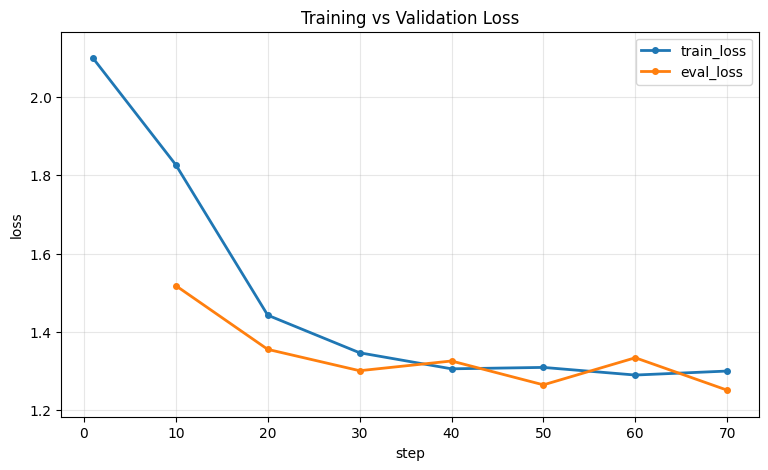

Plot guardado en: outputs/Qwen__Qwen2.5-7B-Instruct-7B_targets_normales/loss_curves.png
Métricas CSV: outputs/Qwen__Qwen2.5-7B-Instruct-7B_targets_normales/train_val_metrics.csv


In [14]:
dfm = pd.read_csv(METRICS_CSV)
for c in ("step","train_loss","eval_loss","lr"):
    if c in dfm.columns: dfm[c] = pd.to_numeric(dfm[c], errors="coerce")
dfm = dfm.dropna(subset=["train_loss","eval_loss","lr"], how="all")
dfm = dfm.sort_values("step").groupby("step", as_index=False).last()

xs_tr = dfm["step"].to_numpy()
ys_tr = dfm["train_loss"].to_numpy()
xs_ev = dfm["step"].to_numpy()
ys_ev = dfm["eval_loss"].to_numpy()

plt.figure(figsize=(9,5))
if np.isfinite(ys_tr).any(): plt.plot(xs_tr, ys_tr, "-o", label="train_loss", lw=2, ms=4)
if np.isfinite(ys_ev).any(): plt.plot(xs_ev, ys_ev, "-o", label="eval_loss",  lw=2, ms=4)

vals = np.concatenate([a[~np.isnan(a)] for a in [ys_tr, ys_ev] if len(a)])
if len(vals):
    pad = max(1e-4, 0.08*(vals.max()-vals.min()))
    plt.ylim(vals.min()-pad, vals.max()+pad)

plt.title(f"Training vs Validation Loss — {SAFE_MODEL_NAME}")
plt.xlabel("step"); plt.ylabel("loss"); plt.title("Training vs Validation Loss")
plt.grid(alpha=0.3); plt.legend()
plt.savefig(PLOT_PATH, dpi=150, bbox_inches="tight")
plt.show()

print("Plot guardado en:", PLOT_PATH)
print("Métricas CSV:", METRICS_CSV)

## Experimento (mlflow -> Databricks)

In [15]:
import mlflow
from datetime import datetime
from mlflow.data import from_pandas

# Configuración MLflow
os.environ["DATABRICKS_HOST"] = KEYS.DATABRICKS_HOST
os.environ["DATABRICKS_TOKEN"] = KEYS.DATABRICKS_TOKEN
mlflow.set_tracking_uri("databricks")
mlflow.set_experiment(f"/GeneracionDeResumenes/Resultados_Modelos")

mlflow.end_run()
run_name = f"{SAFE_MODEL_NAME}-{datetime.now().strftime('%Y%m%d_%H%M%S')}"

DESCRIPTION = "7B_targets_normales"    ######################## Agregar detallesd e la corrida en particular

with mlflow.start_run(run_name=run_name):
    ds_train = from_pandas(train_df, source="Cochrane", name="Cochrane_v1")
    mlflow.set_tag("mlflow.note.content", DESCRIPTION)
    mlflow.log_input(ds_train, context="training")
    mlflow.log_params({
        "model_id": MODEL_ID,
        "PEFT":"LoRa",
        "sliding_window": USE_SLIDING_WINDOW,
        "sw_window_toks": SW_WINDOW_TOKS,
        "sw_overlap_toks": SW_OVERLAP_TOKS,
        "sw_fusion_mode": SW_FUSION_MODE,
        "icl_mode": ICL_MODE,
        "fp16": True,
        "cut_off_len": CUT_OFF_LEN,
        "max_new_tokens": MAX_NEW_TOKENS,
        "temperature": TEMPERATURE,
        "top_p": TOP_P,
        "epochs": NUM_EPOCHS,
        "batch_train": BATCH_TRAIN,
        "batch_eval": BATCH_EVAL,
        "grad_acc_steps": GRAD_ACC_STEPS,
        "lr": LR,
        "lora_r": LORA_R,
        "lora_alpha": LORA_ALPHA,
        "lora_dropout": LORA_DROPOUT,
        "loss_weights": json.dumps(LOSS_WEIGHTS),
        "n_train_rows": len(train_df),
        "n_val_rows": len(val_df),
    })      

    # Métricas finales (si existen en CSV)
    try:
        df_metrics = pd.read_csv(METRICS_CSV)
        for c in ("step","train_loss","eval_loss"):
            if c in df_metrics.columns:
                df_metrics[c] = pd.to_numeric(df_metrics[c], errors="coerce")
        last_train = df_metrics["train_loss"].dropna().iloc[-1] if "train_loss" in df_metrics and df_metrics["train_loss"].notna().any() else None
        last_eval  = df_metrics["eval_loss"].dropna().iloc[-1]  if "eval_loss" in df_metrics and df_metrics["eval_loss"].notna().any() else None
        if last_train is not None: mlflow.log_metric("train_loss_last", float(last_train))
        if last_eval  is not None: mlflow.log_metric("eval_loss_last",  float(last_eval))
    except Exception as e:
        print("[MLflow] Aviso: no pude leer métricas CSV:", e)

    # Artefactos
    if os.path.exists(METRICS_CSV): mlflow.log_artifact(METRICS_CSV, artifact_path="metrics")
    if os.path.exists(PLOT_PATH):    mlflow.log_artifact(PLOT_PATH,    artifact_path="plots")

    # Guarda adapters y tokenizer como artefactos
    #mlflow.log_artifacts(FINAL_DIR, artifact_path="model_final")

print("MLflow: experimento registrado. Tracking URI:", mlflow.get_tracking_uri())


d:\OneDrive\Documents\MAIA\Semestre 4\Despliegue de Soluciones\__REPOS__\Generacion-de-resumenes.-medicos\.venv_generacion\lib\site-packages\mlflow\data\dataset_source_registry.py:148: UserWarning: Failed to determine whether UCVolumeDatasetSource can resolve source information for 'Cochrane'. Exception: 
  return _dataset_source_registry.resolve(
d:\OneDrive\Documents\MAIA\Semestre 4\Despliegue de Soluciones\__REPOS__\Generacion-de-resumenes.-medicos\.venv_generacion\lib\site-packages\mlflow\data\dataset_source_registry.py:148: UserWarning: The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
  return _dataset_source_registry.resolve(
d:\OneDrive\Documents\MAIA\Semestre 4\Despliegue de Soluciones\__REPOS__\Generacion-de-resumenes.-medicos\.venv_generacion\lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains intege

🏃 View run Qwen__Qwen2.5-7B-Instruct-20251113_223723 at: https://dbc-2d843358-2bd3.cloud.databricks.com/ml/experiments/3629258298816718/runs/68a4910948564caa8f730f3a34db5151
🧪 View experiment at: https://dbc-2d843358-2bd3.cloud.databricks.com/ml/experiments/3629258298816718
MLflow: experimento registrado. Tracking URI: databricks


In [16]:
from IPython.display import Markdown

def export_code_cells():
    from IPython import get_ipython
    cells = get_ipython().user_ns['In']
    code = '\n\n'.join([c for c in cells if c.strip()])
    return Markdown(f'```python\n{code}\n```')

#export_code_cells()